# HOMEWORK 14

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [148]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

C:\Users\User\AppData\Local\Temp\ipykernel_21488\3862496557.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[idx])])


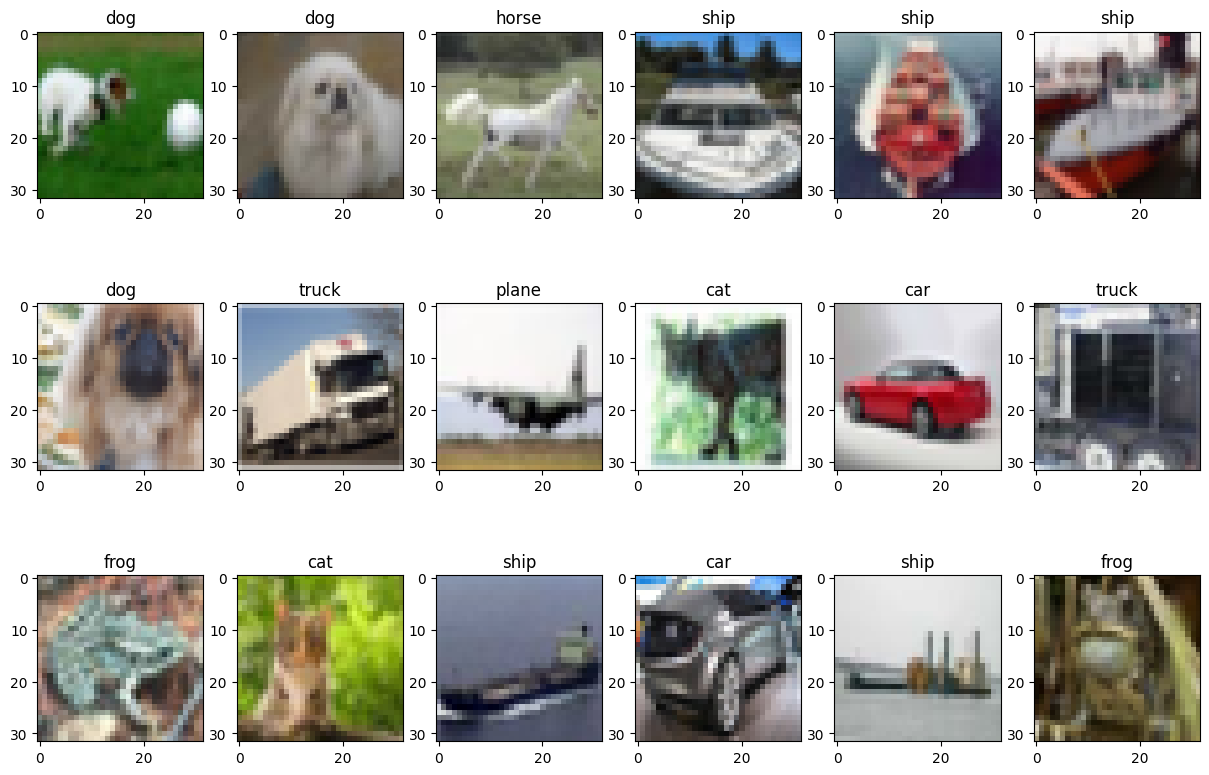

In [135]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):    
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = np.random.randint(x_train.shape[0])
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])

Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

(Text(0.5, 0, 'Class ID'), Text(0, 0.5, 'Counts'))

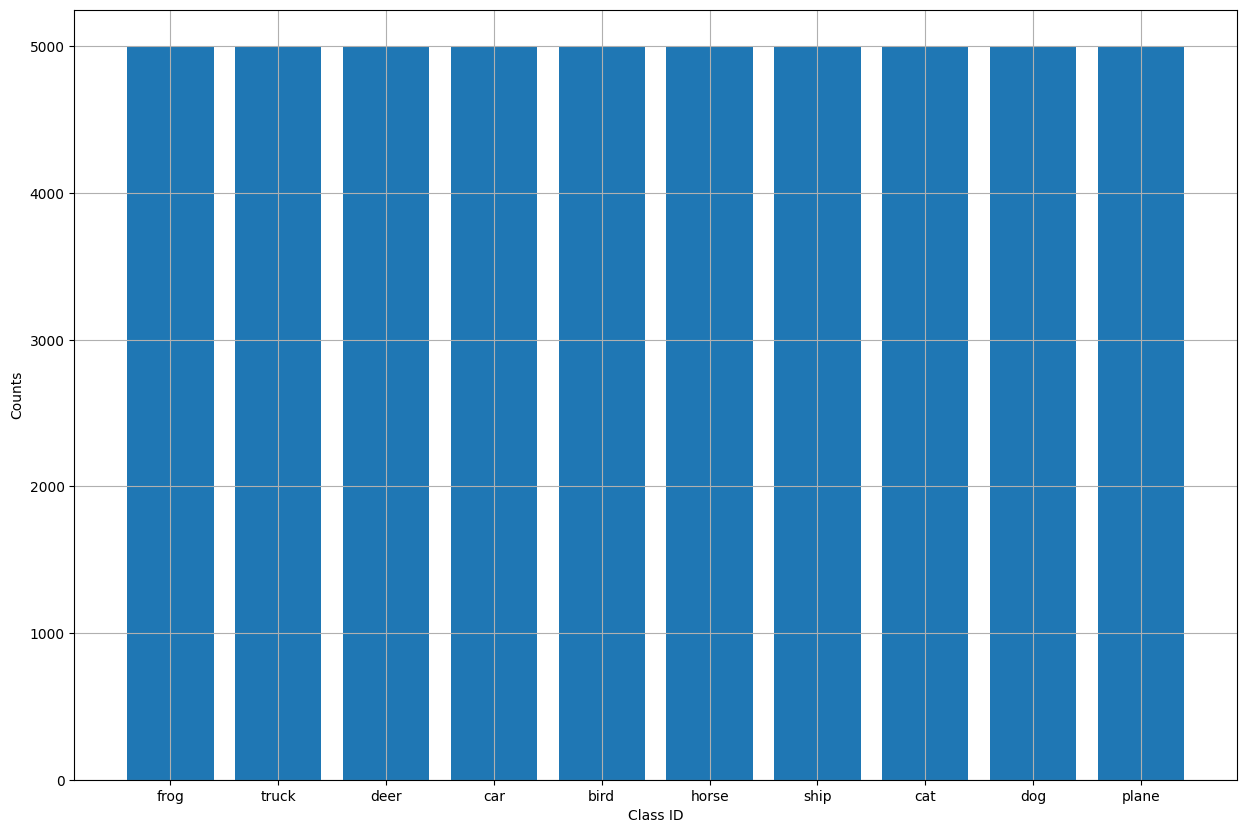

In [137]:
# Compute the class histogram 
from collections import Counter

# Flatten the labels array
y_train_flat = np.array(y_train, dtype=np.int64).flatten()

# Compute the class histogram using Counter
train_histogram = Counter(y_train_flat)

train_histogram_readable = {classes[class_id]: count for class_id, count in train_histogram.items()}

plt.bar(train_histogram_readable.keys(), train_histogram_readable.values()), plt.grid(True)
plt.xlabel('Class ID'), plt.ylabel('Counts')


### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [138]:
# Normalization
x_train = x_train/255
x_test = x_test/255

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [139]:
# Build the classifier
inputs = Input(shape=(size, size, 3))

net = Conv2D(16, kernel_size=(3, 3), activation='relu')(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation='relu')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
outputs = Dense(num_classes, activation='softmax')(net)

model = Model(inputs, outputs)

# Show the model
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,618 (64.91 KB)

 Trainable params: 16,618 (64.91 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training

Compile the model and train it.

In [140]:
epochs = 25
batch_size = 128

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
print('Elapsed time', time() - start)

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2968 - loss: 1.9434 - val_accuracy: 0.4460 - val_loss: 1.5891
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4764 - loss: 1.4823 - val_accuracy: 0.4904 - val_loss: 1.4502
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5216 - loss: 1.3615 - val_accuracy: 0.5270 - val_loss: 1.3379
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5529 - loss: 1.2824 - val_accuracy: 0.5522 - val_loss: 1.2579
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5751 - loss: 1.2240 - val_accuracy: 0.5744 - val_loss: 1.2070
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5899 - loss: 1.1799 - val_accuracy: 0.5910 - val_loss: 1.1662
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6030 - loss: 1.1434 - val_accuracy: 0.6036 - val_loss: 1.1356
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6168 - loss: 1.1124 - val_accuracy: 0.

Train Acc      0.9724444150924683
Validation Acc 0.7911999821662903


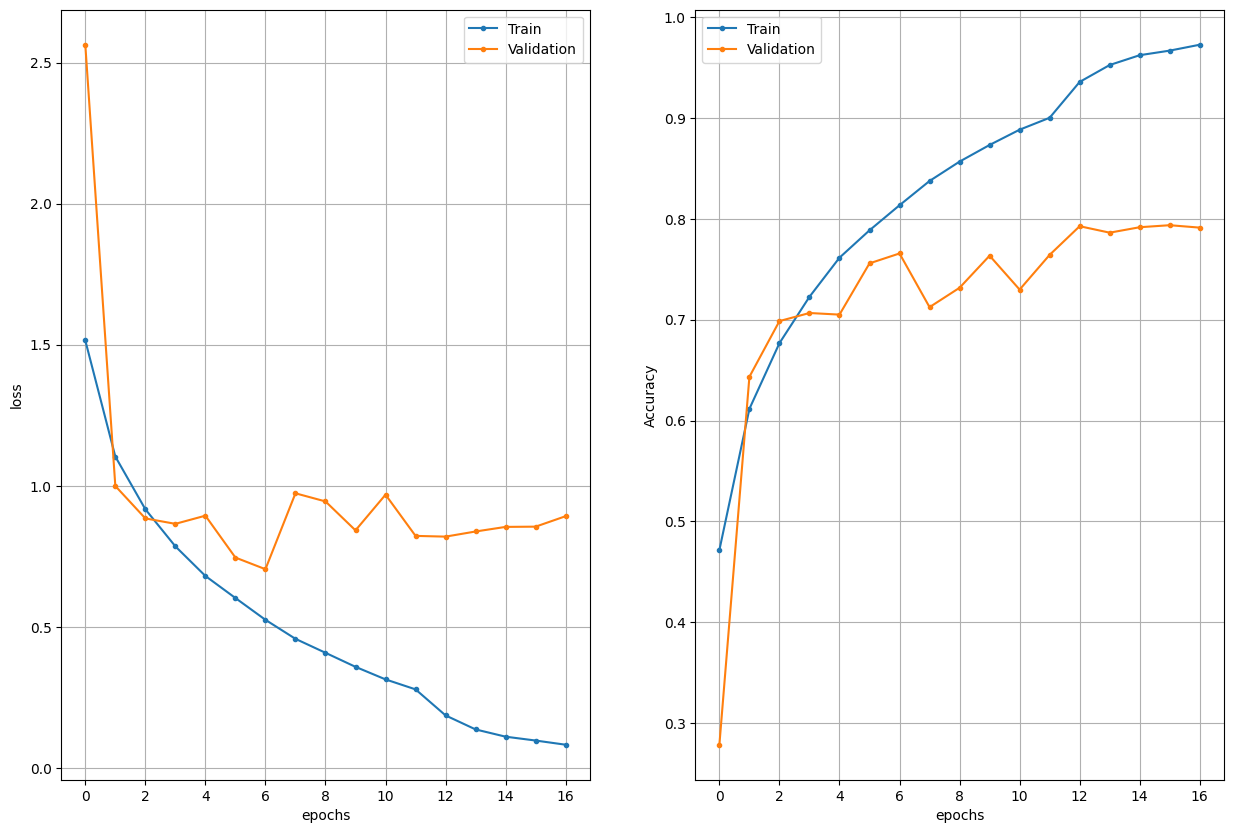

In [161]:
# Show training history (this cell is complete, nothing to implement here :-) )
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])

plot_history(history)

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [142]:
# Compute the labels and the predictions as sparse values
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(x_test)

print('True', y_true[0:5])
print('Pred', np.argmax(y_pred[0:5, :], axis=1))
print('Pred', y_pred[0:5, :])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
True [3 8 8 0 6]
Pred [3 1 1 0 4]
Pred [[2.3987435e-03 9.1438553e-05 9.5638307e-03 8.5462660e-01 9.3373284e-03
  9.3236230e-02 2.5730321e-02 3.6916183e-04 3.8021053e-03 8.4415724e-04]
 [4.2818461e-02 9.1051722e-01 3.6447596e-05 5.8508704e-07 4.4306116e-06
  1.1436709e-07 7.1091524e-09 1.8276900e-06 3.1810589e-02 1.4810347e-02]
 [1.3814050e-01 4.5067567e-01 2.3675128e-03 4.7151200e-03 2.9713872e-03
  2.9817389e-04 2.1405520e-04 1.3117781e-03 3.1459036e-01 8.4715478e-02]
 [5.0298589e-01 1.0550792e-01 1.0888518e-02 7.3320803e-04 5.0936965e-03
  2.1386624e-05 3.0982785e-04 4.8913169e-03 3.6760390e-01 1.9643651e-03]
 [1.2948832e-05 3.8694325e-05 2.5703657e-02 4.6427764e-02 6.3677877e-01
  7.9549951e-03 2.8262961e-01 2.0573907e-04 1.5514942e-04 9.2638555e-05]]


In [143]:
y_pred = np.argmax(y_pred, axis=1)

num_samples = len(y_true)
# Compute and print the accuracy for each class
for class_id, class_name in classes.items():
    mask = y_true == class_id
    total = np.sum(mask)
    
    acc = np.sum(y_pred[mask] == class_id)/total
    print(class_name, acc)

plane 0.703
car 0.755
bird 0.539
cat 0.469
deer 0.696
dog 0.496
frog 0.806
horse 0.682
ship 0.733
truck 0.746


In [144]:
# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6637 - loss: 0.9829
Test loss   0.9905863404273987
Test metric 0.6625000238418579


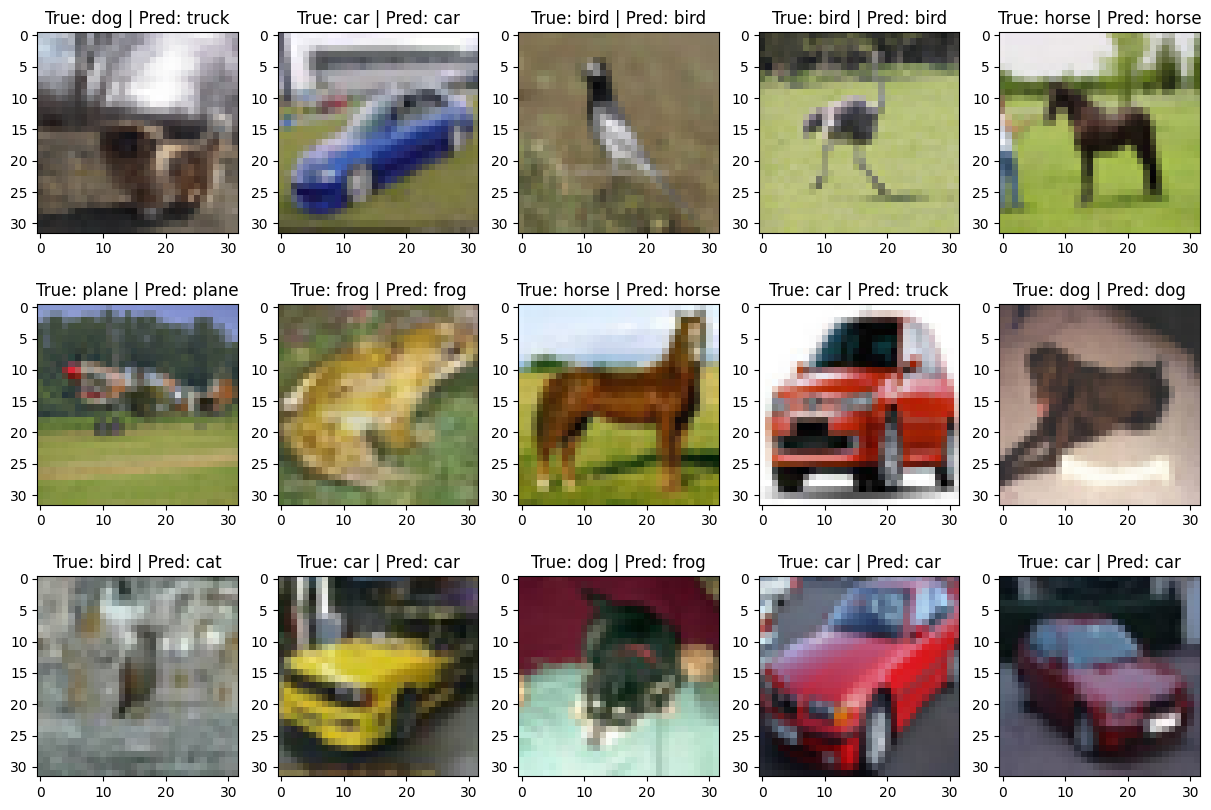

In [145]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(x_test.shape[0])
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))

### Questions
* What is the overall accuracy of the classifier?
* What modifications would you do in order to improve the classification accuracy?
* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?

## Answers
* Overall accuracy of the classifier is 0.6637
* To improve accuracy we could add layers to model

In [169]:
inputs = Input(shape=(size, size, 3))

net = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(net)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(net)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
net = Dense(512, activation='relu')(net)
net = Dropout(0.5)(net)
outputs = Dense(num_classes, activation='softmax')(net)

model = Model(inputs, outputs)

In [170]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 25
batch_size = 128

# Training with data augmentation
start = time()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_split=0.1,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])
print('Elapsed time', time() - start)

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.3885 - loss: 1.9820 - val_accuracy: 0.3116 - val_loss: 2.3249 - learning_rate: 0.0010
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5941 - loss: 1.1456 - val_accuracy: 0.6240 - val_loss: 1.0799 - learning_rate: 0.0010
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.6712 - loss: 0.9318 - val_accuracy: 0.7102 - val_loss: 0.8520 - learning_rate: 0.0010
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.7210 - loss: 0.8012 - val_accuracy: 0.7238 - val_loss: 0.7964 - learning_rate: 0.0010
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.7494 - loss: 0.7144 - val_accuracy: 0.7036 - val_loss: 0.8551 - learning_rate: 0.0010
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.7800 - loss: 0.6233 - val_accuracy: 0.7510 - val_loss: 0.7476 - learning_rate: 0.0010
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8075 - l

Train Acc      0.9674666523933411
Validation Acc 0.7922000288963318


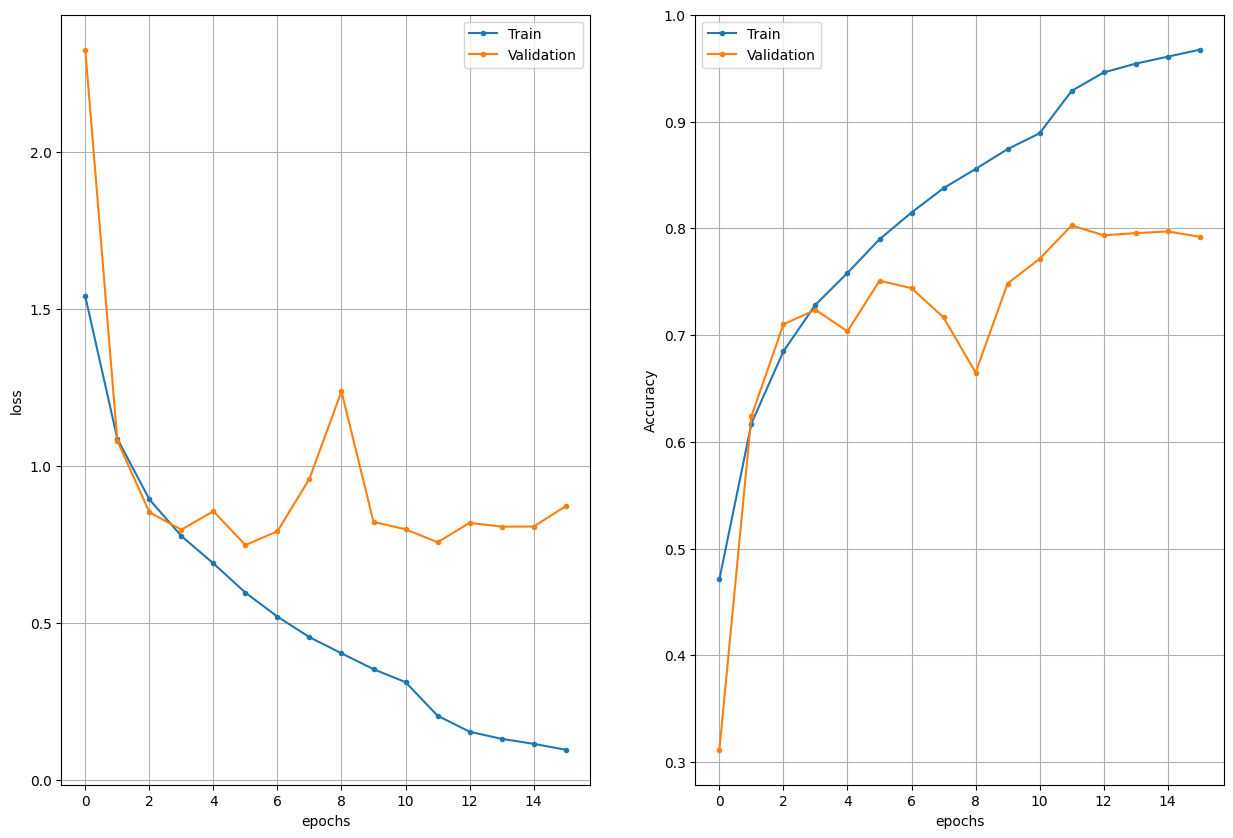

In [171]:
plot_history(history)

In [172]:
ev = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7388 - loss: 0.7678


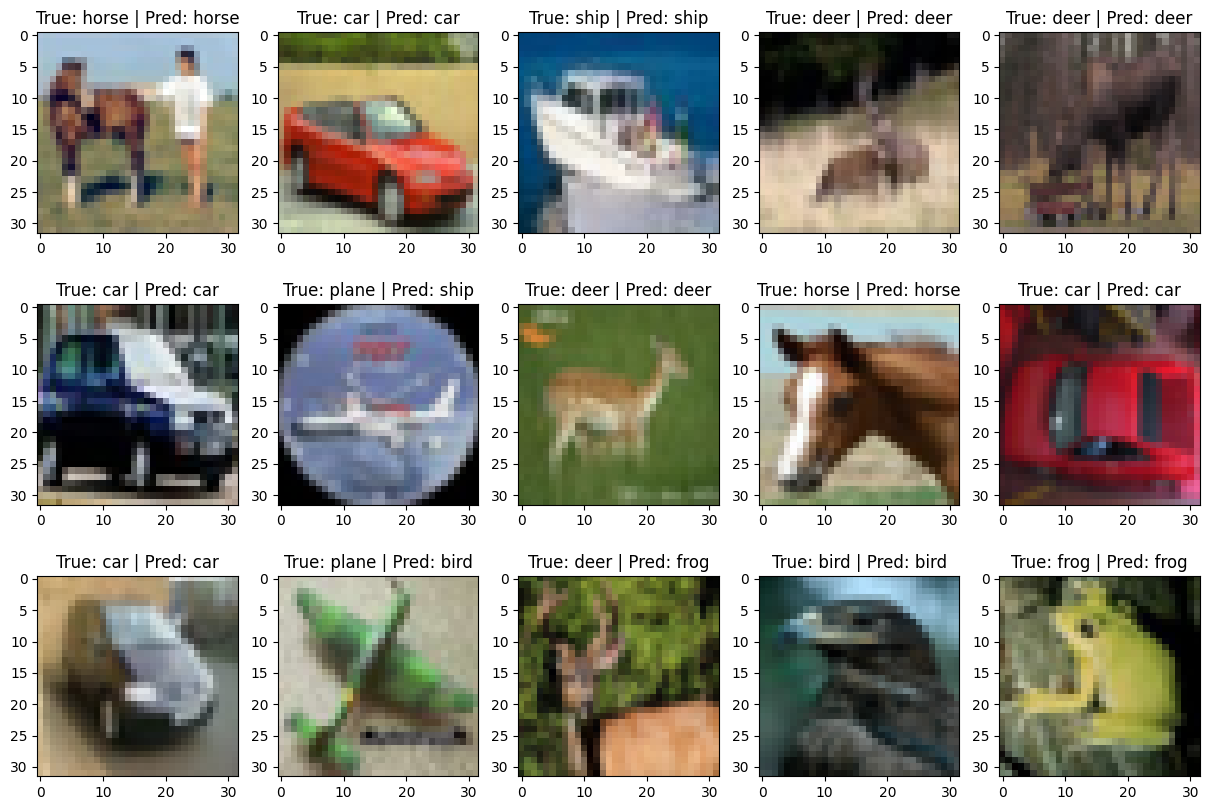

In [173]:
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(x_test.shape[0])
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))